In [ ]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.layers import Dense,Input,LSTM,GlobalMaxPooling1D,Embedding,MaxPooling1D,Conv1D,Concatenate,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

File ‘ml-20m.zip’ already there; not retrieving.



In [ ]:
!unzip -n 'ml-20m.zip'

Archive:  ml-20m.zip


In [ ]:
!ls ml-20m

genome-scores.csv  links.csv   ratings.csv  tags.csv
genome-tags.csv    movies.csv  README.txt


In [ ]:
df = pd.read_csv('ml-20m/ratings.csv')

In [ ]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


Non va bene per come sono codificati, è necessario che i vari id siano consecutivi


In [ ]:
def change_if(df,col):
  map={}
  idx=0
  
  for x in df[col]:
    if x not in map.keys():
      map[x]=idx
      idx+=1
  df[col+"_encoded"]=df[col].map(map)

In [ ]:
#change_if(df,'userId')
#change_if(df,'movieId')

In [ ]:
df.userId=pd.Categorical(df.userId)
df['userId_encoded']=df.userId.cat.codes

In [ ]:
df.userId=pd.Categorical(df.movieId)
df['movieId_encoded']=df.movieId.cat.codes

In [ ]:
df.head()

,userId,movieId,rating,timestamp,userId_encoded,movieId_encoded
0,1,2,3.5,1112486027,0,0
1,1,29,3.5,1112484676,0,1
2,1,32,3.5,1112484819,0,2
3,1,47,3.5,1112484727,0,3
4,1,50,3.5,1112484580,0,4


In [ ]:
len(df['userId'].unique())

138493

In [ ]:
df['userId_encoded'].max()

138492

In [ ]:
num_users=len(df['userId'].unique())
num_movies=len(df['movieId'].unique())

embedding_dim=10

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(df[['userId_encoded','movieId_encoded']],df['rating'],test_size=0.2)

In [ ]:
u = Input(shape=(1,))

m = Input(shape=(1,))


u_emb = Embedding(num_users,embedding_dim)(u)

m_emb=Embedding(num_movies, embedding_dim)(m)

u_emb=Flatten()(u_emb)
m_emb=Flatten()(m_emb)

# le dimensioni non devono essere necessariamente uguali, ma perché no?

x = Concatenate()([u_emb,m_emb])

# ANN

x = Dense(1024,activation='relu')(x)
x=Dense(1)(x)


model=Model(inputs=[u,m],outputs=x)

In [ ]:
avg_ratings=y_train.mean()
y_train=y_train-avg_ratings
y_test=y_test-avg_ratings

In [ ]:
model.compile(
    optimizer=tf.optimizers.SGD(lr=0.08,momentum=0.9),
    loss='mse',
)

r = model.fit(
    [x_train['userId_encoded'],x_train['movieId_encoded']],
    y_train,
    validation_data=([x_test['userId_encoded'],x_test['movieId_encoded']],y_test),
    batch_size=1024,
    epochs=10
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


13087/13087 [==============================] - 176s 13ms/step - loss: 1.1073 - val_loss: 1.1071
Epoch 2/20
13087/13087 [==============================] - 195s 15ms/step - loss: 1.1065 - val_loss: 1.1070
Epoch 3/20
13087/13087 [==============================] - 191s 15ms/step - loss: 1.1065 - val_loss: 1.1070
Epoch 4/20
13087/13087 [==============================] - 176s 13ms/step - loss: 1.1065 - val_loss: 1.1070
Epoch 5/20
13087/13087 [==============================] - 173s 13ms/step - loss: 1.1065 - val_loss: 1.1070
Epoch 6/20
13087/13087 [==============================] - 172s 13ms/step - loss: 1.1063 - val_loss: 1.1061
Epoch 7/20
13087/13087 [==============================] - 172s 13ms/step - loss: 1.0520 - val_loss: 1.0282
Epoch 8/20
13087/13087 [==============================] - 193s 15ms/step - loss: 1.0248 - val_loss: 1.0229
Epoch 9/20
13087/13087 [==============================] - 193s 15ms/step - loss: 1.0178 - val_loss: 1.0107
Epoch 10/20
13087/13087 [=======================

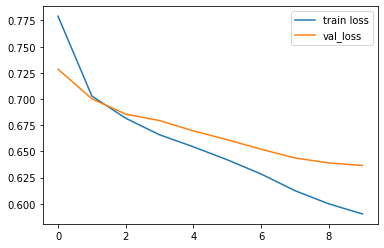

In [ ]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],
label='val_loss')
plt.legend()